# Week 5 - Regularization

## Aims

By the end of this notebook you will be able to 

>* perform regulized regression in sklearn
>* understand the role of tuning parameter(s)
>* use cross-validation for model tuning and comparison.

1. [Problem Definition and Setup](#setup)
2. [Exploratory Data Analysis](#eda)
3. [Baseline Model](#baseline)
4. [Ridge Regression](#ridge)
4. [Lasso Regression](#lasso)
4. [ElasticNet Regression](#elasticnet)

During workshops, you will complete the worksheets together in teams of 2-3, using **pair programming**. You should aim to switch roles between driver and navigator approximately every 15 minutes. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given.

---

# Problem Definition and Setup<a id='setup'></a>

## Packages

First, let's load some of the packages you wil need for this workshop (we will load others as we progress).

In [1]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

## User Defined Helper Functions

We will make use of the two helper functions that we used last week. 

In [2]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [3]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return Metrics

## Data

The data for this week's workshop comes from the Elements of Statistical Learning textbook. The data originally come from a study by [Stamey et al. (1989)](https://www.sciencedirect.com/science/article/abs/pii/S002253471741175X)  in which they examined the relationship between the level of prostate-specific antigen (`psa`) and a number of clinical measures in men who were about to receive a prostatectomy. The variables are as follows,

* `lpsa` - log of the level of prostate-specific antigen
* `lcavol` - log cancer volume
* `lweight` - log prostate weight
* `age` - patient age
* `lbph` - log of the amount of benign prostatic hyperplasia
* `svi` - seminal vesicle invasion
* `lcp` - log of capsular penetration
* `gleason` - Gleason score
* `pgg45` - percent of Gleason scores 4 or 5
* `train` - test / train split used in ESL

These data are available in `prostate.csv`, which is included in the workshop materials.

Let's start by reading in the data.

In [4]:
prostate = pd.read_csv('prostate.csv')
prostate.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


# Exploratory Data Analysis<a id='eda'></a>

Before modelling, we will start with EDA to gain an understanding of the data, through descriptive statistics and visualizations. 

### 🚩 Exercise 1 (CORE)

a) Examine the data structure, look at the descriptive statistics, and create a pairs plot. Do any of our variables appear to be categorical / ordinal rather than numeric?

b) Are there any interesting patterns in these data? Which variable appears likely to have the strongest relationship with `lpsa`? Why do you think we are exploring the relationship between these variables and `lpsa` (log of psa) rather than just psa?

In [5]:
# For general info 
prostate.info()

# For the summary statistics
prostate.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   svi      97 non-null     int64  
 5   lcp      97 non-null     float64
 6   gleason  97 non-null     int64  
 7   pgg45    97 non-null     int64  
 8   lpsa     97 non-null     float64
 9   train    97 non-null     object 
dtypes: float64(5), int64(4), object(1)
memory usage: 7.7+ KB


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,0.216495,-0.179366,6.752577,24.381443,2.478387
std,1.178625,0.428411,7.445117,1.450807,0.413995,1.398250,0.722134,28.204035,1.154329
min,-1.347074,2.374906,41.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,-0.430783
25%,0.512824,3.375880,60.000000,-1.386294,0.000000,-1.386294,6.000000,0.000000,1.731656
50%,1.446919,3.623007,65.000000,0.300105,0.000000,-0.798508,7.000000,15.000000,2.591516
75%,2.127041,3.876396,68.000000,1.558145,0.000000,1.178655,7.000000,40.000000,3.056357
max,3.821004,4.780383,79.000000,2.326302,1.000000,2.904165,9.000000,100.000000,5.582932


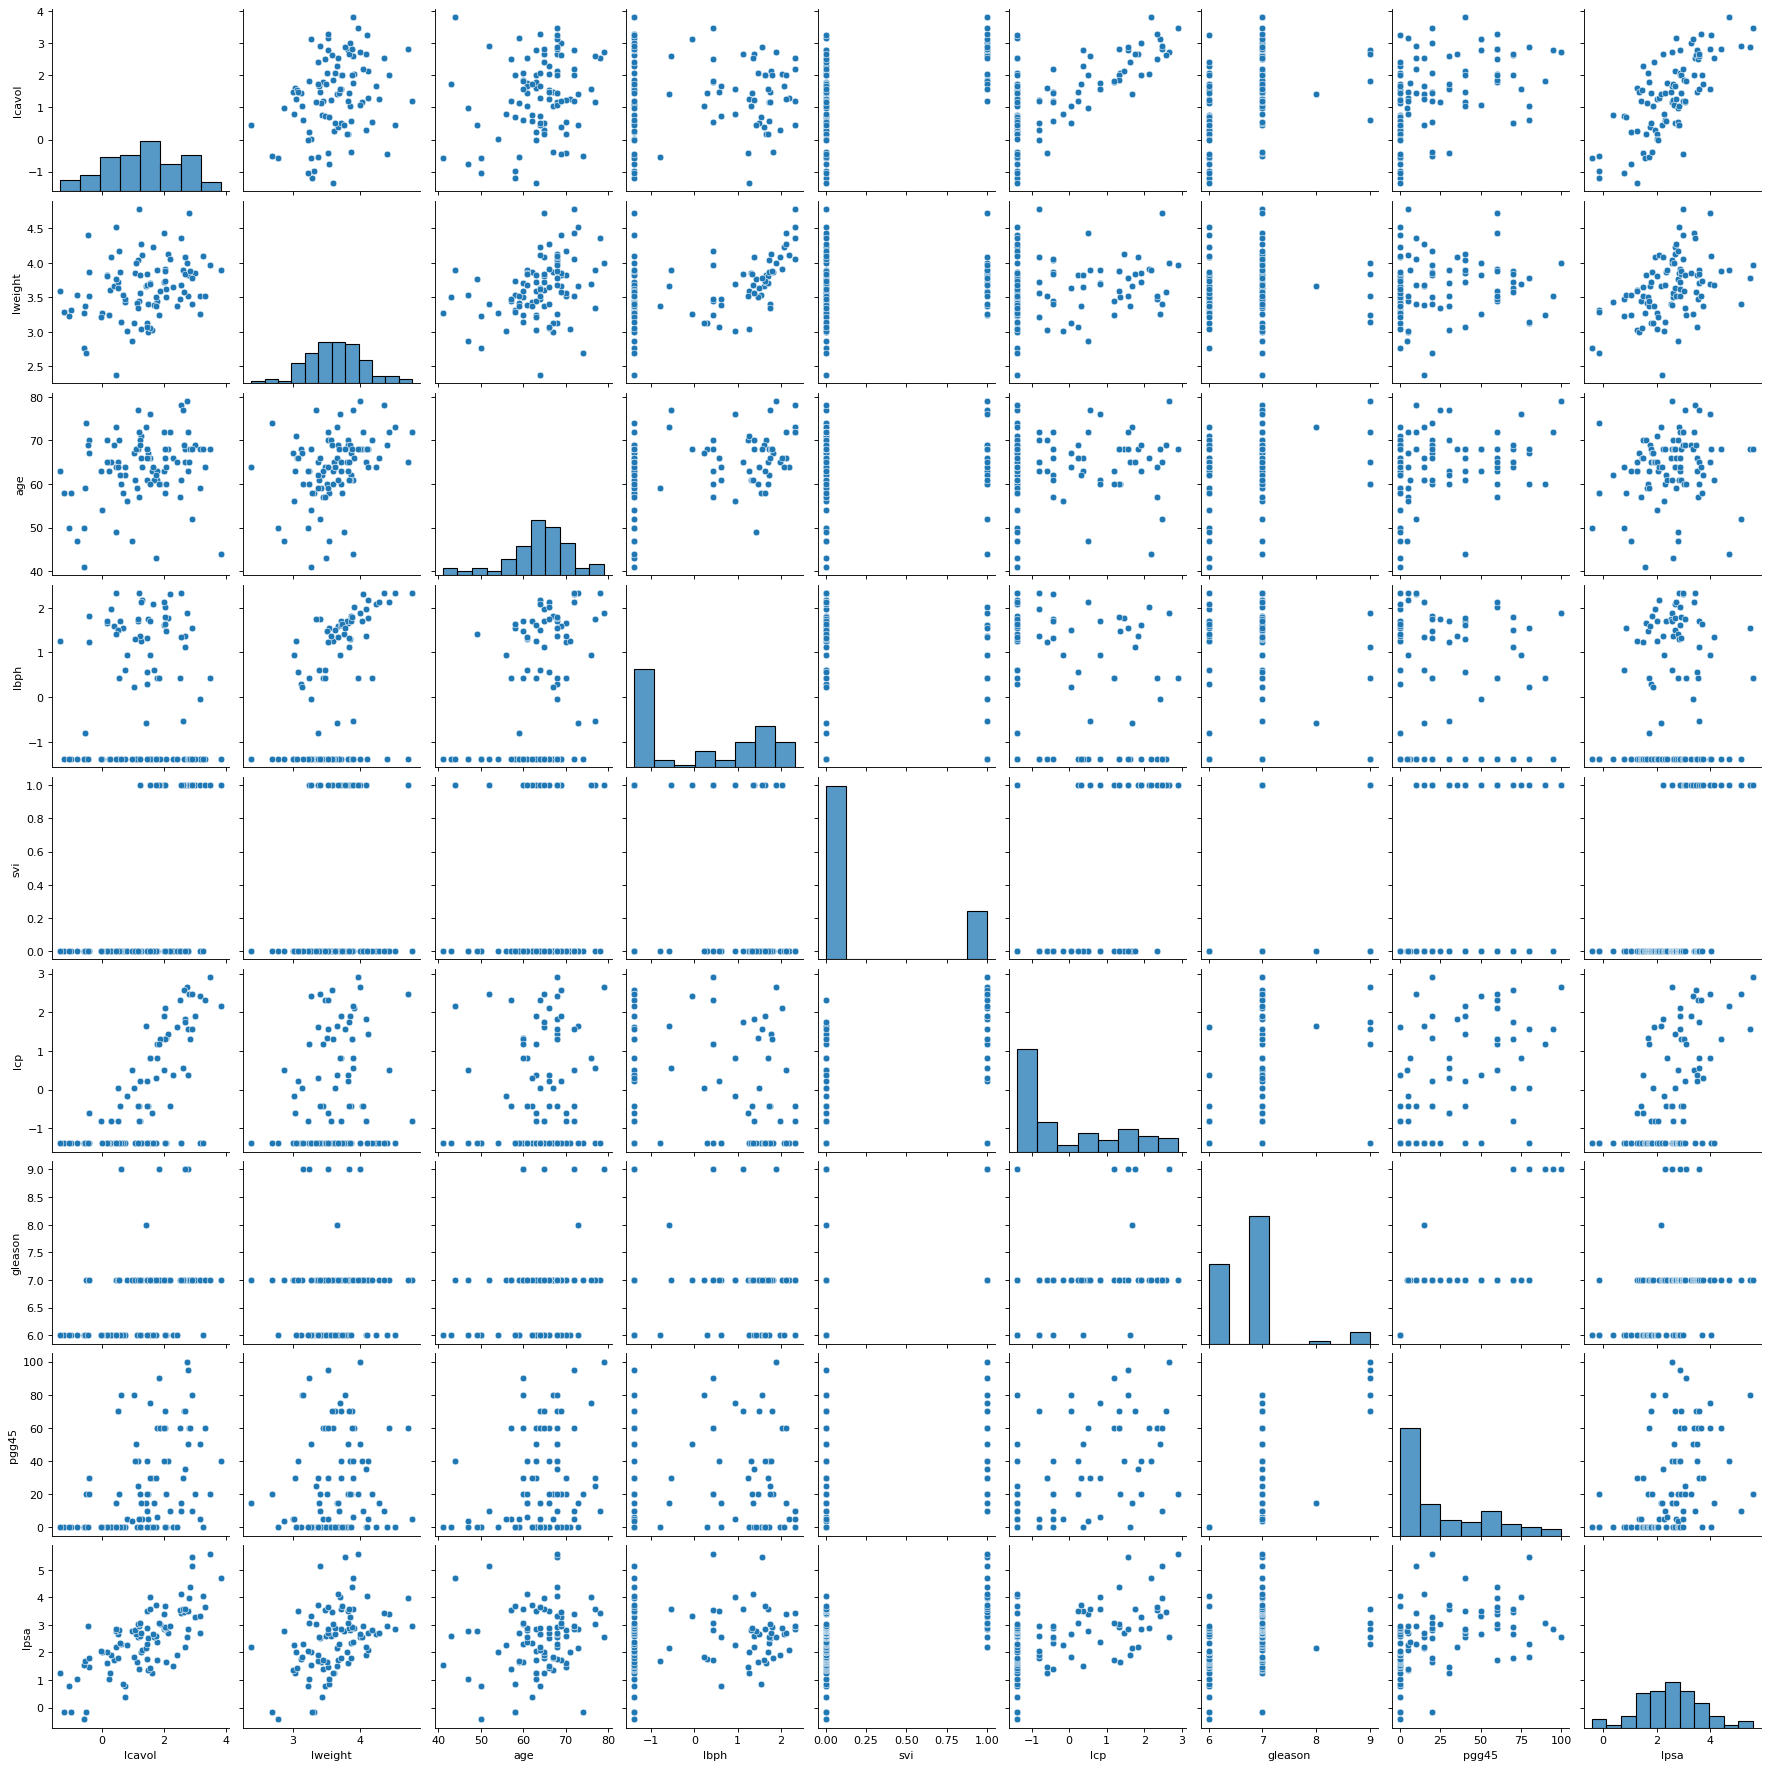

In [6]:
sns.pairplot(prostate)
plt.show()

There are $N=97$ observations with no missingness.

- The variables `age` and `ppg45` are integer valued, with latter representing a percent and restricted to the range $[0,100]$.
- The variable `svi` is binary and the variable `gleason` is and ordered categorical variable
- The other variables are numerical.

We see that both `lcavol` and `lcp` seem to have a linear relationship with the response `lspa`.

The response `lpsa` is the log of psa, and this transformation has been applied because on the original scale `psa` is very right skewed, and the log transformation gives a symmetric and more "normal" distribution.

## Train-Test Set <a id='gen'></a>

For these data we have already been provided a column to indicate which values should be used for the training set and which for the test set. This is encoded by the values in the `train` column - we can use these columns to separate our data and generate our training data: `X_train` and `y_train` as well as our test data `X_test` and `y_test`. 

In [7]:
# Create train and test data frames
train = prostate.query("train == 'T'").drop('train', axis=1)
test = prostate.query("train == 'F'").drop('train', axis=1)

In [8]:
# Training data
X_train = train.drop(['lpsa'], axis=1)
y_train = train.lpsa

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)

X_train: (67, 8)
y_train: (67,)


In [9]:
# Test data
X_test = test.drop('lpsa', axis=1)
y_test = test.lpsa

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_test: (30, 8)
y_test: (30,)


Let's also fix the random seed to make this notebook's output identical at every run

In [10]:
# Fix seed
rng = np.random.seed(0)

# Baseline model<a id='baseline'></a>

Our first task is to fit a baseline model which we will be able to use as a point of comparison for our subsequent models. A good candidate for this is a simple linear regression model that includes all of our features.

In [11]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train, y_train)

We can extract the coefficients for the model, which correspond to the variables: `intercept`, `lcavol`, `lweight`, `age`, `lbph`, `svi`, `lcp`, `gleason`, and `pgg45` respectively.

In [12]:
print(np.c_[np.append(['intercept'],lm.feature_names_in_),np.round(get_coefs(lm),4)])

[['intercept' 0.4292]
 ['lcavol' 0.5765]
 ['lweight' 0.614]
 ['age' -0.019]
 ['lbph' 0.1448]
 ['svi' 0.7372]
 ['lcp' -0.2063]
 ['gleason' -0.0295]
 ['pgg45' 0.0095]]


These coefficients have the typical regression interpretation, e.g. for each unit increase in `lcavol` we expect `lpsa` to increase by 0.5765 on average. These values are not of particular interest for us for this particular problem as we are more interested in the predictive properties of our model(s). To evaluate this we will use the `model_fit` helper function.

### 🚩 Exercise 2 (CORE)

Use the `model_fit` function to evaluate both the model fit on the training data and the predictions on the test data. 

- Based on these plots do you see anything in the fit or residual plot that is potentially concerning? 
- Do you expect the MSE on test data to be better or worse than the MSE on the training data?

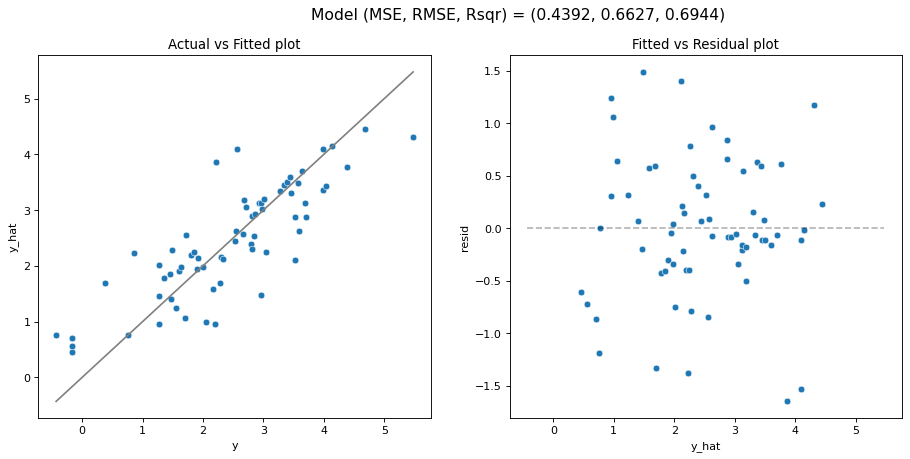

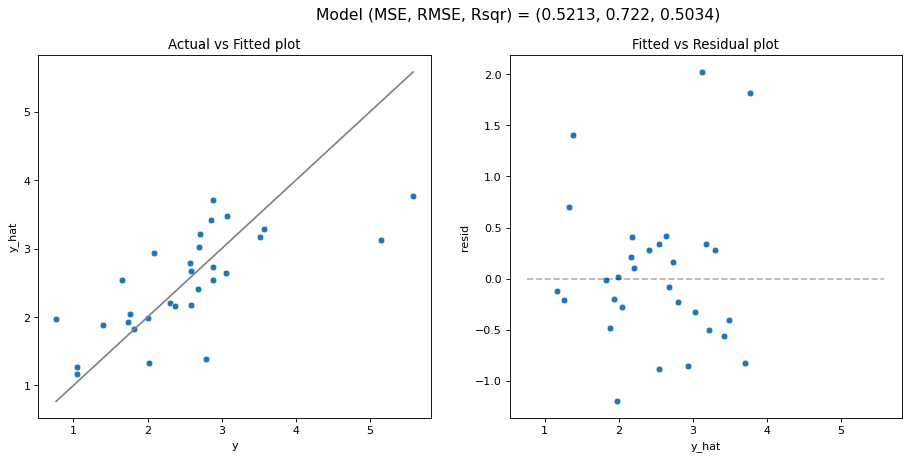

In [13]:
lm_metrics_train = model_fit(lm, X_train, y_train, plot=True)
lm_metrics_test = model_fit(lm, X_test, y_test, plot=True)

- The model appears to be having difficulties with the smallest and largest values of `lpsa`, i.e. small values are over-predicted (negative residuals) while larger values are underpredicted (positive residuals).
- Generally, the test data have worse MSE than the training data since fitting the least squares estimate is equivalent to minimizing the MSE. The training fit has a better MSE than our testing fit.

In [14]:
print('Training MSE:',lm_metrics_train[0])
print('Test MSE:',lm_metrics_test[0])

Training MSE: 0.4392
Test MSE: 0.5213


## Standardization

In subsequent sections we will be exploring the use of the Ridge and Lasso regression models which both penalize larger values of $\mathbf{w}$. While not particularly bad, our baseline model had coefficients that ranged from the smallest at 0.0095 to the largest at 0.737 which is about a 78x difference in magnitude. This difference can be made even worse if we were to change the units of one of our features, e.g. changing a measurement in kg to grams would change that coefficient by 1000 which has no effect on the fit of our linear regression model (predictions and other coefficients would be unchanged) but would have a meaningful impact on the estimates given by a Ridge or Lasso regression model, since that coefficient would now dominate the penalty term.

To deal with this issue, the standard approach is to standaridize all features. Additionally, the feature values can now be interpreted as the number of standard deviations each observation is away from that column's mean.
Using `sklearn` we can perform this transformation using the `StandardScaler` transformer from the preprocessing submodule.

Keep in mind, that in order to get a realistic idea of the performance of model on the test data, **the mean and standard deviation used to standardize both the training and test sets should be computed from the training data only**.  The best way to accomplish this is to include the StandardScaler in a modeling pipeline for your data

### 🚩 Exercise 3 (CORE)

Consider the following pipeline that first standardizes the features before linear regression. Fit the model to the training data.  Using this new model what has changed about our model results? Comment on both the model's coefficients as well as its predictive performance. How has the interpretation of coefficients changed?

In [15]:
from sklearn.preprocessing import StandardScaler

lm_s = make_pipeline(
    StandardScaler(),
    LinearRegression()
).fit(X_train, y_train)

In [16]:
print(np.c_[np.append(['intercept'],lm_s.feature_names_in_),np.round(get_coefs(lm_s),4)])

[['intercept' 2.4523]
 ['lcavol' 0.711]
 ['lweight' 0.2905]
 ['age' -0.1415]
 ['lbph' 0.2104]
 ['svi' 0.3073]
 ['lcp' -0.2868]
 ['gleason' -0.0208]
 ['pgg45' 0.2753]]


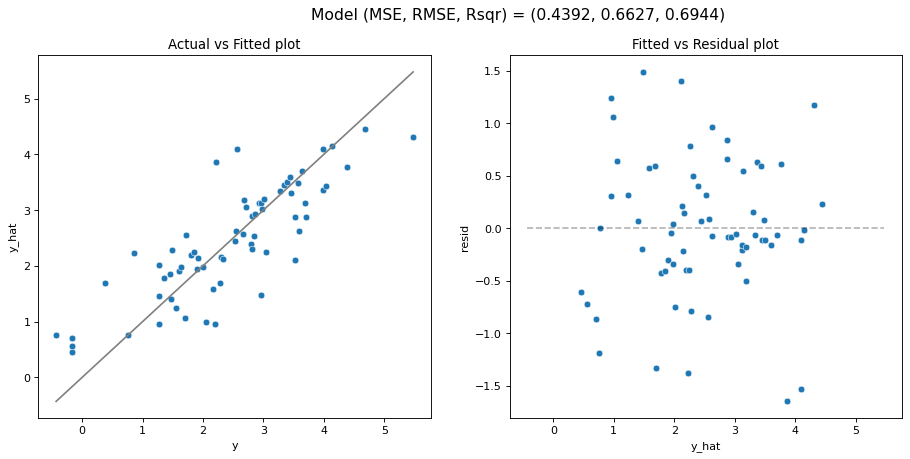

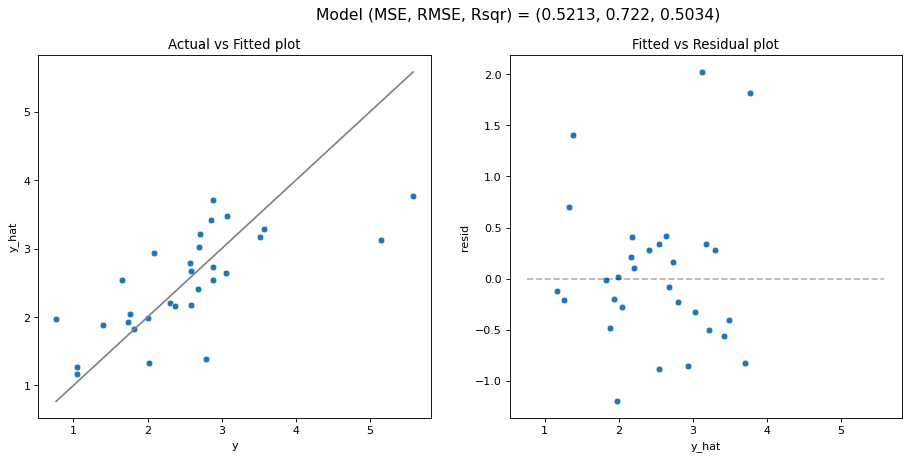

In [17]:
lms_metrics_train = model_fit(lm_s, X_train, y_train, plot=True)
lms_metrics_test = model_fit(lm_s, X_test, y_test, plot=True)

In [18]:
print('Training MSE:',lm_metrics_train[0])
print('Test MSE:',lm_metrics_test[0])

Training MSE: 0.4392
Test MSE: 0.5213


Standardizing the features causes the coefficients to change but the model is effectively the same and has the same predictive performance as the previous model. The coefficients now reflect the change in `lpsa` if the feature is increased by one standard deviation.

Note that by adding the `StandardScaler()` step in the pipeline, we have standardized all features, including the binary and ordinal features. This makes interpreting the coefficients of the binary and ordinal features more challenging. Because of this, some practioners prefer to only standardize the numerical variables; in that case, you can use `ColumnTransformer()` to apply standardization only to the numerical variables. 

We can check the mean and standard deviation used to standardize the features by accessing the `.mean_` and `.scale_` attributes of the `StandardScaler()`. Notice the values used to transform the binary variable `svi`. 

In [19]:
ss = StandardScaler().fit(X_train)
print(np.c_[ss.feature_names_in_,np.round(ss.mean_,4)])
print(np.c_[ss.feature_names_in_,np.round(ss.scale_,4)])

[['lcavol' 1.3135]
 ['lweight' 3.6261]
 ['age' 64.7463]
 ['lbph' 0.0714]
 ['svi' 0.2239]
 ['lcp' -0.2142]
 ['gleason' 6.7313]
 ['pgg45' 26.2687]]
[['lcavol' 1.2333]
 ['lweight' 0.473]
 ['age' 7.446]
 ['lbph' 1.4527]
 ['svi' 0.4168]
 ['lcp' 1.3902]
 ['gleason' 0.7036]
 ['pgg45' 29.0823]]


In [20]:
print('After standardizing, the orginal value of 0 for svi is replaced with',np.round(-ss.mean_[4]/ss.scale_[4],4) )
print('After standardizing, the orginal value of 1 for svi is replaced with',np.round((1-ss.mean_[4])/ss.scale_[4],4) )

After standardizing, the orginal value of 0 for svi is replaced with -0.5371
After standardizing, the orginal value of 1 for svi is replaced with 1.8619


When standardizing all features, if we are interested in interpreting the value of the coefficients, we should **unstandardize** the coefficients. Letting $\tilde{\mathbf{x}}$ denote the standardized features and $\hat{\mathbf{w}}$ denote the estimated coeffcients when training with standardized features, we have that:

$$ \text{E}[y | \tilde{\mathbf{x}}] = \hat{w}_0 + \hat{w}_1\tilde{x}_1 + \ldots + \hat{w}_D\tilde{x}_D.$$

Noting that $\tilde{x}_d = (x_d- \bar{x}_d)/s_d$ (where $\bar{x}_d$ and $s_d$ represent the sample mean and standard deviation), we can transform back to the original space:

$$ \text{E}[y | \mathbf{x}] = \hat{w}_0 + \hat{w}_1(x_1-\bar{x}_1)/s_1 + \ldots + \hat{w}_D(x_D-\bar{x}_D)/s_D.$$

Thus, 
$$ \text{E}[y | \mathbf{x}] = \left( \hat{w}_0 - \sum_d \bar{x}_d/s_d \right)+ \hat{w}_1/s_1 x_1+ \ldots + \hat{w}_D/s_D  x_D.$$

And, the *unstandardized* coefficients are obtain by dividing $\hat{\mathbf{w}}$ by the standard deviations.

### 🚩 Exercise 4 (CORE)

Unstandardize the coefficients and interpret the effect of the binary variable `svi`.

In [21]:
ucoef = lm_s['linearregression'].coef_/lm_s['standardscaler'].scale_
print(np.c_[lm_s.feature_names_in_,np.round(ucoef,4)])

[['lcavol' 0.5765]
 ['lweight' 0.614]
 ['age' -0.019]
 ['lbph' 0.1448]
 ['svi' 0.7372]
 ['lcp' -0.2063]
 ['gleason' -0.0295]
 ['pgg45' 0.0095]]


We expect the prescence of a seminal vesicle invasion to increase the log of the level of prostate-specific antigen by 0.7372.

# Ridge Regression<a id='ridge'></a>

Ridge regression is a natural extension to linear regression which introduces an $\ell_2$ penalty on the coefficients in a standard least squares problem. 

The [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) model is provided by the `linear_model` submodule. Note that the penalty parameter (referred to as $\lambda$ in the lecture notes) is called `alpha` is sklearn, and, as discussed in lectures, this parameter crucially determines the amount of shrinkage towards zero and the weight of the $\ell_2$ penalty.

After defining the ridge regression model via, e.g. `Ridge(alpha = 1)`, the usual methods can be called, such as `.fit()` to fit the model and `.predict()` to make predictions. 

As for the `LinearRegression()`, after fitting, the intercept and coefficients are stored separately in the attributes `.intercept_` and `.coef_`. In Ridge, this is helpful as it highlights how the penalty is only applied to the coefficient (i.e. we do not want to shrink the intercept).  

Let's start by fitting a ridge regression model with $\alpha=1$.

In [22]:
from sklearn.linear_model import Ridge

[['intercept' 2.4523]
 ['lcavol' 0.6854]
 ['lweight' 0.2896]
 ['age' -0.1343]
 ['lbph' 0.2084]
 ['svi' 0.3016]
 ['lcp' -0.2545]
 ['gleason' -0.0113]
 ['pgg45' 0.256]]


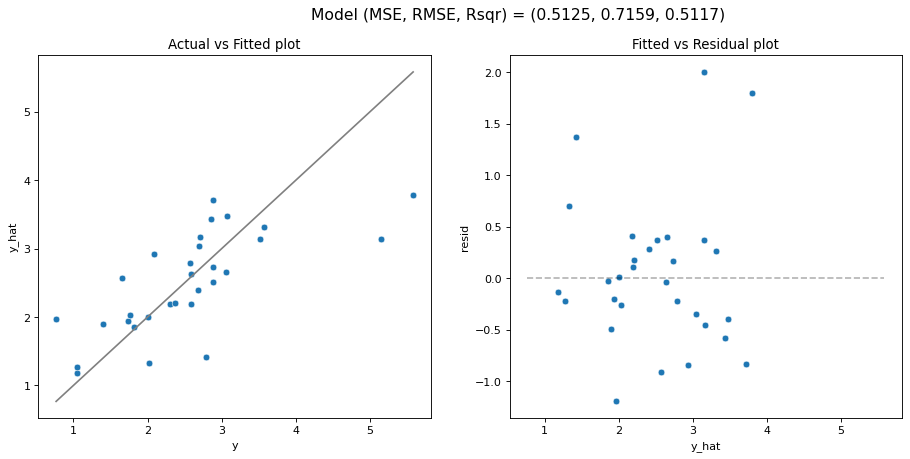

(0.5125, 0.7159, 0.5117)

In [23]:
# Selected alpha value 
alpha_val = 1

r = make_pipeline(
    StandardScaler(),
    Ridge(alpha = alpha_val)
).fit(X_train, y_train)

print(np.c_[np.append(['intercept'],r.feature_names_in_),np.round(get_coefs(r),4)])

model_fit(r, X_test, y_test, plot = True)

### 🚩 Exercise 5 (CORE)

Adjust the value of `alpha` in the cell above and rerun it. Qualitatively, how does the model fit change as alpha changes? How does the MSE change? 


The model fit does not change much but MSE improves as alpha is increased until around $\alpha=20$.


## Solution path: Ridge coeffcients as a function of $\alpha$

A useful way of examining the behavior of Ridge regression models is to plot the **solution path** of the coefficents $\mathbf{w}$ as a function of the penalty parameter $\alpha$. Since Ridge regression is equivalent to linear regression when $\alpha=0$, we can see that as we increase the value of $\alpha$, we are shrinking all of the coefficients in $\mathbf{w}$ towards zero asymptotically $\alpha$ approaches infinity.

In [24]:
alphas = np.logspace(-2, 3, num=200) # from 10^-2 to 10^3

ws = [] # Store coefficients
mses_train = [] # Store training mses
mses_test = [] # Store test mses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Ridge(alpha=a)
    ).fit(X_train, y_train)
    
    ws.append(m[1].coef_) 
    mses_train.append(mean_squared_error(y_train, m.predict(X_train)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test)))

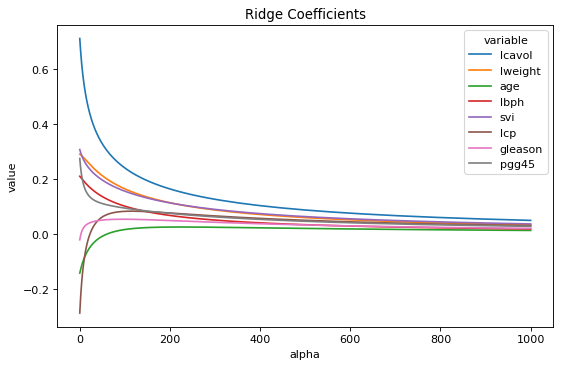

In [25]:
# Create a data frame for plotting
sol_path = pd.DataFrame(
    data = ws,
    columns = X_train.columns # Label columns w/ feature names
).assign(
    alpha = alphas,
).melt(
    id_vars = ('alpha')
)

ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path)
ax.set_title("Ridge Coefficients")
plt.show()

### 🚩 Exercise 6 (CORE)

Based on this plot, which variable(s) seem to be the most important for predicting `lpsa`?

It appears that `lcavol` has the least amount of shrinkage applied, particularly for higher values of $\alpha$, and is therefore likely to be the most important variable for this model. 

### 🚩 Exercise 7 (CORE)

Run the code below to also plot both the training and test MSE as a function of $\alpha$. What do you notice about the MSE as we increase $\alpha$? Which value of $\alpha$ seems better regarding the changes on training and testing MSE values?

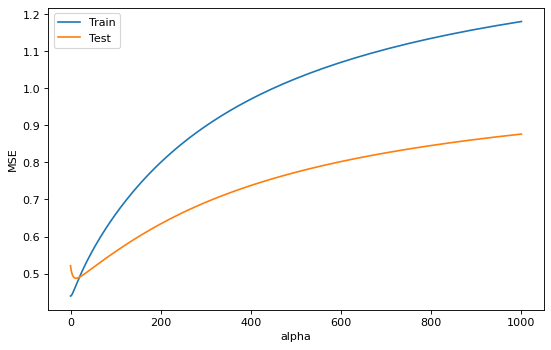

In [26]:
mses_path = pd.DataFrame(
    {'alpha': alphas, 'Train': np.asarray(mses_train), 'Test': np.asarray(mses_test)}).melt(
    id_vars = ('alpha')
)


ax = sns.lineplot(x='alpha', y='value', hue='variable', data=mses_path)
ax.set_ylabel("MSE")
# To remove legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
plt.show()


The training MSE increases as a function of $\alpha$ as expected, since the larger alpha imposes a stronger penalty (decreasing model complexity). The test MSE has more of U-shape, at first decreasing and then increasing when the penalty is too strong.   

In [27]:
alphas[np.argmin(np.asarray(mses_test))-1]

11.62322468679853

## Tuning the penalty parameter with cross-validation

We see that the value of $\alpha$ crucially determines the performance of the ridge regression model. While `RidgeRegression()` uses the default value of `alpha=1`, this should never be used in practice. Instead, this parameter can be tuned using cross-validation. 

As with the polynomial models from last week, we can use `GridSearchCV` to employ k-fold cross validation to determine an optimal $\alpha$. Remember, you can use the method `.get_params()` on your pipeline to list the parameters names to specify in `GridSearchCV`.

In [28]:
# Grid of tuning parameters
alphas = np.linspace(0, 15, num=151)  

#Pipeline
m = make_pipeline(
        StandardScaler(),
        Ridge())

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

# Grid search
gs = GridSearchCV(m,
    param_grid={'ridge__alpha': alphas},
    cv=cv,
    scoring="neg_mean_squared_error")
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4....
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15. ])},
             scoring='neg_mean_squared_error')

Note that we are passing `sklearn.model_selection.KFold(5, shuffle=True, random_state=1234)` to the `cv` argument rather than leaving it to its default. This is because, while not obvious, the prostate data is structured (sorted by `lpsa` value) and this way we are able to ensure that the folds are properly shuffled. Failing to do this causes *very* unreliable results from the cross validation process.

Once fit, we can examine the results to determine what value of $\alpha$ was chosen as well as examine the results of cross validation.

In [29]:
print(gs.best_params_)
print(-gs.best_score_)

{'ridge__alpha': 4.9}
0.7066011634399013


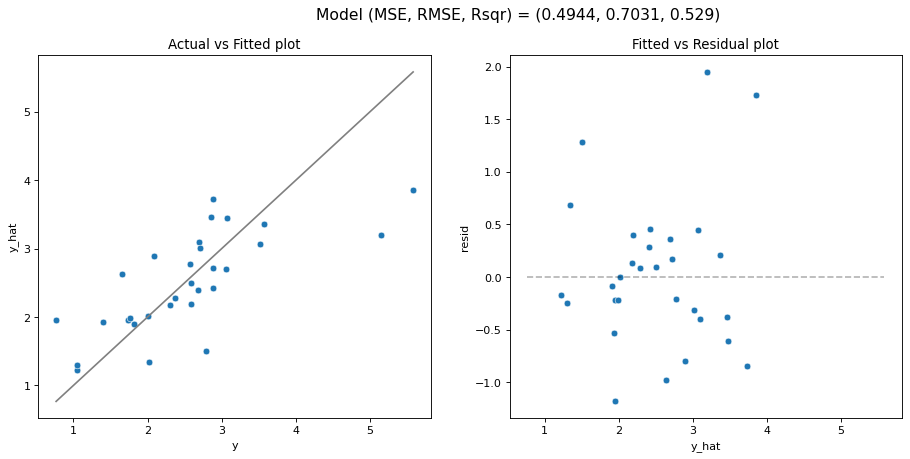

(0.4944, 0.7031, 0.529)

In [30]:
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

### 🚩 Exercise 8 (CORE)

- How does this model compare to the performance of our baseline model? Is it better or worse?

- How do the model coefficients for this model compare to the baseline model? To answer this plot the coefficients for the baseline model against the coefficients for the ridge model. Are they always higher or lower? Now, use `np.linalg.norm` to compute the $\ell_2$ norm of the coeffcients for both models and comment on the results. 

The model performs better than our baseline model (linear regression), as it has a lower RMSE and higher $R^2$.

When comparing the coefficients in the plot below, we find that some coefficients are smaller and some are larger in the ridge model compared to the baseline model. Generally, this may be the case for the ridge coefficients. However, overall, the $\ell_2$ norm of the ridge regression coefficients will be smaller (as shown below for this example). 

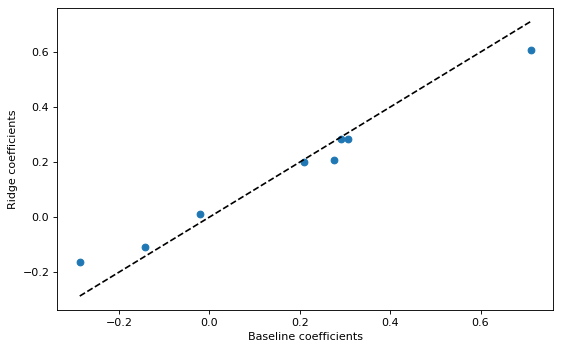

In [31]:
fig, ax = plt.subplots(1,1)
ax.scatter(lm_s[1].coef_, gs.best_estimator_[1].coef_)
x1 = np.min(lm_s[1].coef_)
x2 = np.max(lm_s[1].coef_)
ax.plot([x1,x2],[x1,x2],color='k',linestyle="dashed")
ax.set_xlabel('Baseline coefficients')
ax.set_ylabel('Ridge coefficients')
plt.show()

In [32]:
print('l2 norm of baseline coeffcients',np.linalg.norm(lm_s[1].coef_))
print('l2 norm of ridge coeffcients',np.linalg.norm(gs.best_estimator_[1].coef_))

l2 norm of baseline coeffcients 0.9524432722339883
l2 norm of ridge coeffcients 0.807318313759715


As we saw last week, it is also recommend to plot the CV scores. Although the grid search may report a best value for the parameter corresponding to the maximum CV score (e.g. min CV MSE), if the curve is relatively flat around the minimum, we may prefer the simpler model. 

Recall from last week that we can access the cross-validated scores (along with other results for each split) in the attribute `cv_results_`. 

In [33]:
cv_results = pd.DataFrame(gs.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002577,0.000273,0.001147,0.000199,0.0,{'ridge__alpha': 0.0},-0.933523,-0.684212,-0.732690,-0.424796,-0.789296,-0.712903,0.166571,134
1,0.002008,0.000153,0.000933,0.000212,0.1,{'ridge__alpha': 0.1},-0.934023,-0.685383,-0.733913,-0.422857,-0.786632,-0.712561,0.167126,130
2,0.001887,0.000054,0.000841,0.000017,0.2,{'ridge__alpha': 0.2},-0.934523,-0.686515,-0.735152,-0.420989,-0.783993,-0.712234,0.167674,126
3,0.001860,0.000040,0.000833,0.000027,0.3,{'ridge__alpha': 0.30000000000000004},-0.935022,-0.687609,-0.736407,-0.419188,-0.781380,-0.711921,0.168215,123
4,0.001832,0.000021,0.000823,0.000011,0.4,{'ridge__alpha': 0.4},-0.935519,-0.688668,-0.737675,-0.417453,-0.778793,-0.711622,0.168750,119


In particular, let's examining the `mean_test_score` and the `split#_test_score` keys since these are used to determine the optimal $\alpha$.

In the code below we extract these data into a data frame by selecting our columns of interest along with the $\alpha$ values used (and transform negative MSE values into positive values).

In [34]:
cv_mse = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
    # Add the alphas as a column
    alpha = alphas
)

cv_mse.update(
    # Convert negative mses to positive
    -1 * cv_mse.filter(regex = '_test_score')
)

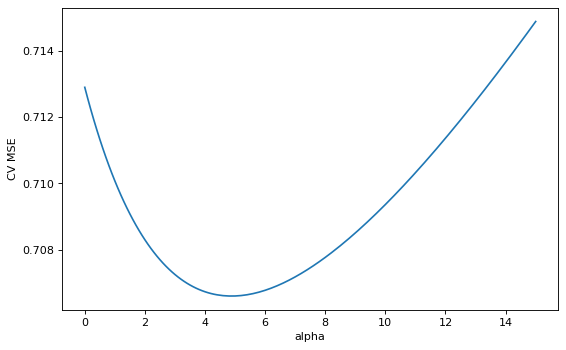

In [35]:
ax = sns.lineplot(x='alpha', y='mean_test_score', data=cv_mse)
ax.set_ylabel('CV MSE')
plt.show()

This plot shows that the value of $\alpha=4.9$ corresponds to the minimum of this curve. However, this plot gives us an overly confident view of this particular value of $\alpha$. Specifically, if instead of just plotting the mean MSE across all of the validation sets, we also examine the MSE for each fold individually and the corresponding optimal value of $\alpha$, we see that there is a lot of noise in the MSE and we should take the value $\alpha = 4.9$ with a grain of salt.

### 🚩 Exercise 9 (CORE)

Run the code below to plot the MSE for each validation set in the 5-fold cross validation. Why do you think that our cross validation results are unstable?

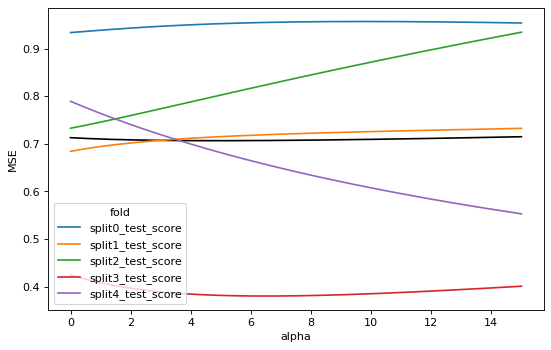

In [36]:
d = cv_mse.melt(
    id_vars=('alpha','mean_test_score'),
    var_name='fold',
    value_name='MSE'
)

sns.lineplot(x='alpha', y='MSE', color='black', errorbar=None, data = d)  # Plot the mean MSE in black.
sns.lineplot(x='alpha', y='MSE', hue='fold', data = d) # Plot the curves for each fold in different colors
plt.show()

The size of training data is $N=67$, which is relatively small. Thus, when we perform five fold cross-validation, for each fold, the number of points in the training and validation sets are small, with only 54 and 13 observations in each, respectively. This produces both unstable estimates of the coefficients when training for each fold and unstable MSE when evaluating on the validation set. 

## Tuning with RidgeCV

Due to the importance of tuning the value of $\alpha$ in ridge regression, sklearn provides a helpful function called [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) which combines `Ridge` with `GridSearchCV`. 

Note however, that `RidgeCV()` only allows to store all results of the cross-validation in the attribute `.cv_results_` in the case of the default leave-one-out cross validation, with option `store_cv_values=True`. So, if you want to access all results and use a cross-validation strategy other than leave-one-out, you will need to use `GridSearchCV`. 

After fitting using `RidgeCV()`, you can access the optimal value of $\alpha$ through the attribute `.alpha_`

### 🚩 Exercise 10 (EXTRA)

Refit the model using the RidgeCV in such a way that you obtain a result similar to what was obtained by `GridSearchCV` (in terms of the optimal $\alpha$ and test MSE).

*Note: `RidgeCV` does not allow `alpha=0` for some reason, so you will need to start your grid of parameters at a small positive value.*

*Note: the results will not exactly agree. This is because `GridSearchCV` will carry out standardization of features on each fold, while `RidgeCV` carries it out only once. If the standardization is relatively stable across folds, the results will agree.* 

In [37]:
from sklearn.linear_model import RidgeCV

# Grid of tuning parameters
alphas = np.linspace(0.1, 15, num=151) # RidgeCV does not allow alpha=0 for some reason

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

# Ridge CV
rcv = RidgeCV(alphas=alphas, cv=cv, scoring = "neg_mean_squared_error")

#Pipeline
gs2 = make_pipeline(
        StandardScaler(),
        rcv)
gs2.fit(X_train, y_train)

print( "alpha:", gs2["ridgecv"].alpha_)
print( "(MSE, RMSE, R2):", model_fit(gs2, X_test, y_test) )

alpha: 4.470666666666666
(MSE, RMSE, R2): (0.4956, 0.704, 0.5278)


# Lasso Regression<a id='lasso'></a>

We saw that ridge regression with a wise choice of $\alpha$ can outperform our baseline linear regression. We can now investigate if lasso can yield a more accurate or interpretable solution. Recall that lasso uses an $\ell_1$ penalty on the coefficients, as opposed to the $\ell_2$ penalty of ridge. 

The [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) model is also provided by the `linear_model` submodule and similarly requires the choice of the tuning parameter `alpha` to determine the weight of the $\ell_1$ penalty. 

Try running the code below with different values of $\alpha$ to see how it effects sparsity in the coefficients and model performance.

[['intercept' 2.4523]
 ['lcavol' 0.5648]
 ['lweight' 0.2096]
 ['age' 0.0]
 ['lbph' 0.0579]
 ['svi' 0.136]
 ['lcp' 0.0]
 ['gleason' 0.0]
 ['pgg45' 0.035]]


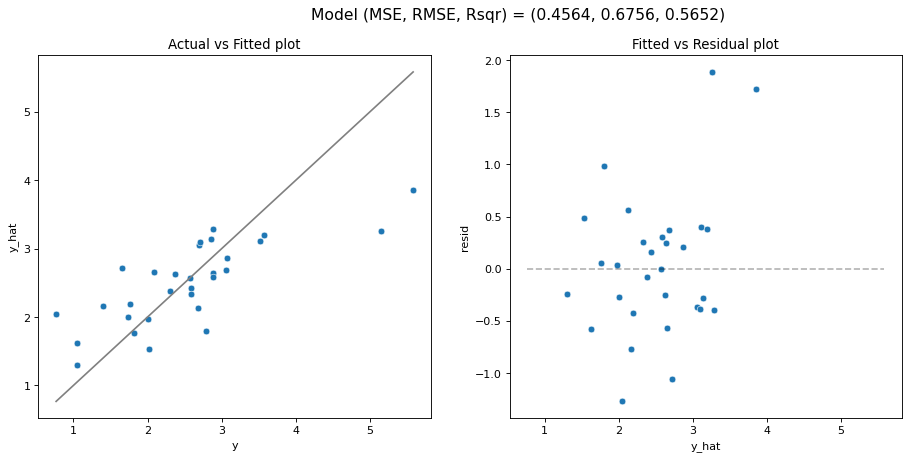

(0.4564, 0.6756, 0.5652)

In [38]:
from sklearn.linear_model import Lasso

# Selected alpha value 
alpha_val = 0.15

l = make_pipeline(
    StandardScaler(),
    Lasso(alpha = alpha_val)
).fit(X_train, y_train)

print(np.c_[np.append(['intercept'],l.feature_names_in_),np.round(get_coefs(l),4)])

model_fit(l, X_test, y_test, plot = True)

### 🚩 Exercise 11 (CORE)

a) Plot the solution path of the coefficients as a function of $\alpha$.

b) How does this differ between the solution path for Ridge? 

c) Which variable seems to be the most important for predicting `lpsa`?

*Note that $\alpha = 0$ causes a warning due to the fitting method (coordinate descent) not converging well without regularization (the $\ell_1$ penalty here). So, the grid of $\alpha$ values needs to start at some small positive constant.*

In [39]:
# Part a: Compute the solution path
alphas = np.linspace(0.01, 1, num=100)

ws = [] # Store coefficients
mses_train = [] # Store training mses
mses_test = [] # Store test mses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Lasso(alpha=a)
    ).fit(X_train, y_train)
    
    ws.append(m[1].coef_) 
    mses_train.append(mean_squared_error(y_train, m.predict(X_train)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test)))

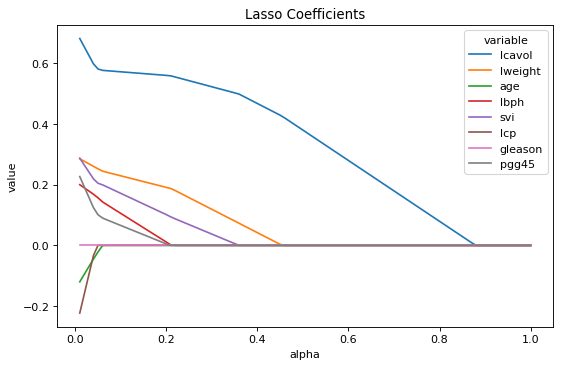

In [40]:
# Part a: Plot the solution path
# Create a data frame for plotting
sol_path = pd.DataFrame(
    data = ws,
    columns = X_train.columns # Label columns w/ feature names
).assign(
    alpha = alphas,
).melt(
    id_vars = ('alpha')
)

ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path)
ax.set_title("Lasso Coefficients")
plt.show()

b) The values of the coefficients are shrunk to exactly zero as $\alpha$ increases.

c) The variable `lcavol` seems to be the most important, as for values of $\alpha$ approximately between 0.5 and 0.9, it is the only variable included (i.e. it is the last variable whose coefficient is shrunk towards zero). 

## Tuning the Lasso penalty parameter

Again, we can use the `GridSearchCV` function to tune our Lasso model and optimize the $\alpha$ hyperparameter or use [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html), which combines `Lasso` and `GridSearchCV`. 

Unlike `RidgeCV`, the fitted `LassoCV` has an attribute `mse_path_` providing the MSE for each fold in cross validation. 

### 🚩 Exercise 12 (CORE)

a) Use `LassoCV` to find the optimal value of $\alpha$.  

b) Plot the CV MSE and MSE for each fold. Comment on the stability and uncertainty of $\alpha$ across the different folds.

In [41]:
from sklearn.linear_model import LassoCV

# Grid of tuning parameters
alphas = np.linspace(0.01, 1, num=100)

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

# lasso CV
lcv = LassoCV(alphas=alphas, cv=cv)

#Pipeline
gs_lasso = make_pipeline(
        StandardScaler(),
        lcv)
gs_lasso.fit(X_train, y_train)

print( "alpha:", gs_lasso["lassocv"].alpha_)

alpha: 0.01


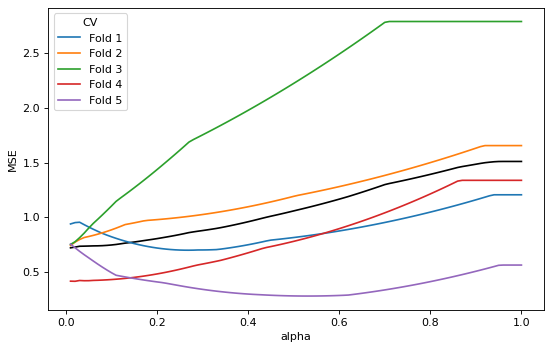

In [42]:
fold_names =[]
[fold_names.append('Fold '+str(i+1)) for i in range(5)]

cv_mse = pd.DataFrame(
    data = gs_lasso["lassocv"].mse_path_, 
    columns = fold_names
).assign(alpha = gs_lasso["lassocv"].alphas_) 

d = cv_mse.melt(
    id_vars=('alpha'),
    var_name='CV',
    value_name='MSE'
)

sns.lineplot(x='alpha', y='MSE', color='black', errorbar=None, data = d)  # Plot the mean MSE in black.
sns.lineplot(x='alpha', y='MSE', hue='CV', data = d) # Plot the curves for each fold in different colors
plt.show()

In this case, the optimal value of $\alpha$ is the minimum value of the grid. Three of the five folds suggest a similar value of $\alpha$, and it seems to be slightly more stable than in the case of ridge. Here, we don't observe the anticipated U-shape in the CV MSE, which may be a bit worrying and suggests that we may need to adjust our grid to include smaller values and/or that the baseline linear regression model (i.e. $\alpha=0$) should be chosen. 

### 🚩 Exercise 13 (CORE)

Run the following code to compute the CV MSE for the linear model and compare with the CV MSE of the lasso model to suggest an optimal value of $\alpha$.

In [43]:
gs_l = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        LinearRegression()
    ),
    param_grid = {},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_mean_squared_error"
).fit(X_train, y_train)

In [44]:
print('CV MSE for baseline linear model', round(gs_l.best_score_ * -1,4))
cv_mse_gl = np.mean(gs_lasso["lassocv"].mse_path_,axis=1)
print('CV MSE for lasso model', round(np.min(cv_mse_gl),4))

CV MSE for baseline linear model 0.7129
CV MSE for lasso model 0.7206


In this case the baseline linear regression model does produce a smaller CV MSE than any of the lasso models. This suggests that we should choose `alpha=0`, i.e. the baseline linear regression model.

### 🚩 Exercise 14 (EXTRA)

Using `ColumnTransfomer`apply standarization to all variables except the binary variable `svi`. How does the affect the lasso solution path?

In [45]:
from sklearn.compose import ColumnTransformer
alphas = np.linspace(0.01, 1, num=100)

ws = [] # Store coefficients
mses_train = [] # Store training mses
mses_test = [] # Store test mses

for a in alphas:
    m = make_pipeline(
        ColumnTransformer([
            ('num',StandardScaler(),[0,1,2,3,5,6,7]), 
            ('binary','passthrough',[4])]),
        Lasso(alpha=a)
    ).fit(X_train, y_train)
    
    ws.append(m[1].coef_) 
    mses_train.append(mean_squared_error(y_train, m.predict(X_train)))
    mses_test.append(mean_squared_error(y_test, m.predict(X_test)))

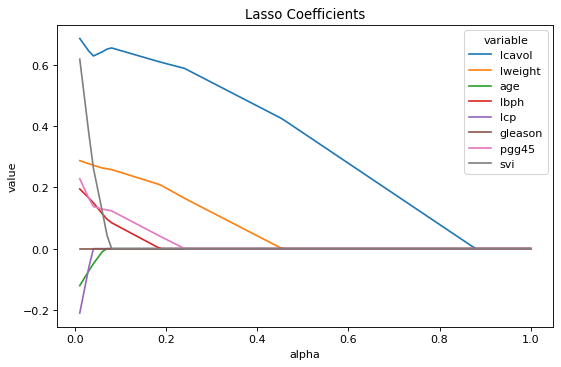

In [46]:
sol_path = pd.DataFrame(
    data = ws,
    columns = X_train.columns[np.array([0,1,2,3,5,6,7,4])] # Label columns w/ feature names
).assign(
    alpha = alphas,
).melt(
    id_vars = ('alpha')
)

ax = sns.lineplot(x='alpha', y='value', hue='variable', data=sol_path)
ax.set_title("Lasso Coefficients")
plt.show()

Previously, the binary variable `svi` was one of the most important predictors following `lcavol` and `lweight`. Now, without standardizing this variable, the penalty applied to the variable is stronger than the other variables because the empirical probability of `svi=1` is around $0.224$ and the standard deviation is around $0.417$ (which is much less than the numerical features which have all been standardized to have unit standard deviation). In fact, `svi` is now one of the least important predictors.

For binary variables with more extremes probabilities (e.g. rare categories in one-hot encoding), the penalty will be even stronger. This may or may not be desirable for the application at hand.

However, if you decide to standardize the binary features, it is important to *unstandardize* the coefficients back into the original space when interpreting the effect. 

# ElasticNet Regression<a id='elasticnet'></a>

Lastly, we can use elastic net regression, which is hybrid between lasso and ridge, including both an $\ell_1$ and $\ell_2$ penalty. The [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) model is again provided by the `linear_model` submodule and minimizes the objective:
$$ \frac{1}{2N} || \mathbf{y} - \mathbf{X}\mathbf{w} ||^2_2 + \alpha \rho ||\mathbf{w}||_1
+ 0.5 \alpha (1 - \rho) ||\mathbf{w}||^2_2.$$

In this parameterization, $\rho$ determines relative strength of the $\ell_1$ penalty compared to the $\ell_2$ and is referred to as `l1_ratio` in `ElasticNet`. Thus, we can also fit ridge and lasso regression models with `ElasticNet` through appropriate choice of `l1_ratio`:
- ridge corresponds to `l1_ratio=0`
- lasso corresponds to `l1_ratio=1`

The parameter $\alpha$ is referred to as `alpha` in `ElasticNet` and controls the overall penalty relative the residual sum of squares. 

The general `ElasticNet` requires tuning of both `alpha` and `l1_ratio`. 

The following code plots the solution path for different choices of `l1_ratio` using the `.path()` method of `ElasticNet`. Notice how the solution paths resemble ridge and lasso for small and large values of `l1_ratio` respectively. 

In this case, `.path()` by default automatically selects a range of `alpha` values, except for the case when `l1_ratio = 0`, i.e. ridge regression. For ridge, you need to supply your own grid of `alpha` values through the option `path(...,alphas=myalphas)`.

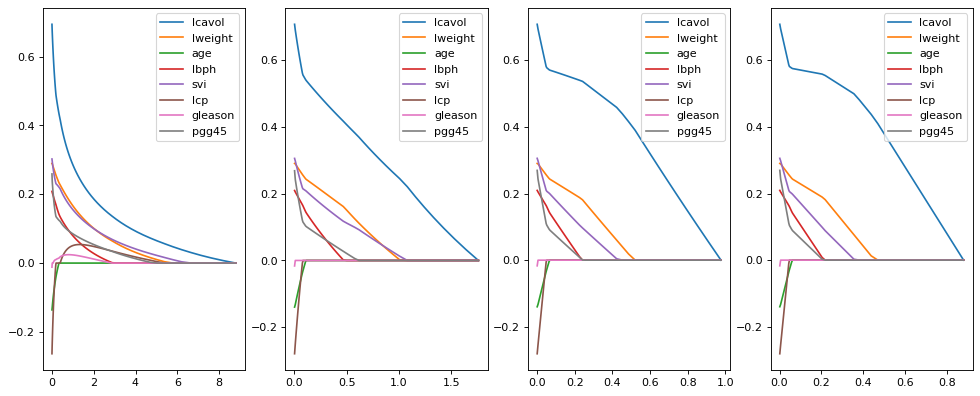

In [47]:
from sklearn.linear_model import ElasticNet

Xs = StandardScaler().fit_transform(X_train)
l1r = [.1, .5, .9, 1]
fig, ax = plt.subplots(1,4,figsize= (15,6))
for i, l in enumerate(l1r):
    sol_path = ElasticNet.path(Xs, y_train, l1_ratio=l)
    d = pd.DataFrame( data = sol_path[1].T, columns = X_train.columns, index = sol_path[0])
    d.plot(ax=ax[i]) 

Again, we can use either `GridSearchCV` or [`ElasticNetCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html) to the parameters. In the following code, we use `ElasticNetCV` to tune both `alpha` and `l1_ratio`. In this case, instead of supplying a grid of `alpha` values, we let `ElasticNetCV` automatically select the values and simply specify the length of the grid through the option `ElasticNetCV(...,n_alphas=100)`. 

As usual, we can access the optimal parameters through the attributes `.alpha_` and `.l1_ratio`, and extract the MSE for each held out validation set through the attribute `.mse_path_`.

In [48]:
from sklearn.linear_model import ElasticNetCV

# Grid of tuning parameters
nalphas = 100 
l1r = [0.01, .1, .5, .7, .9, .95, 1]

# CV strategy
cv = KFold(5, shuffle=True, random_state=1234)

# lasso CV
ecv = ElasticNetCV(n_alphas=nalphas, l1_ratio=l1r, cv=cv)

#Pipeline
gs_en = make_pipeline(
        StandardScaler(),
        ecv)
gs_en.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('elasticnetcv',
                 ElasticNetCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
                              l1_ratio=[0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 1]))])

In [49]:
print( "l1_ratio:", gs_en['elasticnetcv'].l1_ratio_)
print( "alpha:", gs_en['elasticnetcv'].alpha_)
print( "minimum value of alpha in the grid:", np.min(gs_en['elasticnetcv'].alphas_))

l1_ratio: 0.01
alpha: 0.0878880413661538
minimum value of alpha in the grid: 0.000878880413661538


In [50]:
cv_mse_en = np.mean(gs_en["elasticnetcv"].mse_path_,axis=2)
print('CV MSE for elasticnet model', round(np.min(cv_mse_en),4))
print('CV MSE for ridge model',round(-gs.best_score_,4))

CV MSE for elasticnet model 0.708
CV MSE for ridge model 0.7066


### 🚩 Exercise 15 (EXTRA)

Comment on the optimal values of ElasticNet compared with our basineline, ridge, and lasso models. How does the performance of the models compare on the test data?

The optimal value of the `l1_ratio` is the smallest value in the grid, suggesting that a smaller value may be needed or that ridge with `l1_ratio=0` may be the optimal value. When we compare with the CV MSE of the ridge model, it indeed has a smaller CV MSE. 

In [51]:
print('Baseline linear model (MSE, RMSE, R2) =', model_fit(lm_s, X_test, y_test, plot=False))
print('Ridge model (MSE, RMSE, R2) =', model_fit(gs, X_test, y_test, plot = False))
print('Lasso model (MSE, RMSE, R2) =', model_fit(gs_lasso, X_test, y_test, plot = False))
print('ElasticNet model (MSE, RMSE, R2) =', model_fit(gs_en, X_test, y_test, plot = False))

Baseline linear model (MSE, RMSE, R2) = (0.5213, 0.722, 0.5034)
Ridge model (MSE, RMSE, R2) = (0.4944, 0.7031, 0.529)
Lasso model (MSE, RMSE, R2) = (0.4987, 0.7062, 0.5249)
ElasticNet model (MSE, RMSE, R2) = (0.4915, 0.7011, 0.5317)


The ElasticNet model performs slightly better on the test data. 

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name. If you are unable to edit the Notebook Metadata, please add a Markdown cell at the top of the notebook with your name(s).

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF. Once generated, please submit this PDF on Learn page by 16:00 PM on the Friday of the week the workshop was given. 

In [ ]:
!jupyter nbconvert --to pdf mlp_week05_key.ipynb 